# Forecast

Different statistical model can be built for different clusters of households. Forecasts with two different resolutions, hourly and daily, are expected.

In [ ]:
#hide
from elec_consumption.utils import ContextTimer
import datetime
from fbprophet import Prophet
from loguru import logger
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.core.frame import DataFrame
from pandas._libs.tslibs.timestamps import Timestamp
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

Importing plotly failed. Interactive plots will not work.


In [ ]:
#hide
%matplotlib inline
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = [6 * 1.61803398875, 6]
_seed = 123  # for clustering analysis
data = {}  # contain modified dataframes

In [ ]:
#hide
# Import 500 profiles.
df = pd.read_csv('./data/raw.csv', index_col=0)
df.columns = list(range(df.shape[1]))
df.columns.name = 'household'
df.index = pd.to_datetime(df.index)
df.index.name = 'datetime'

## 1. Lag Plot

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 48)'>

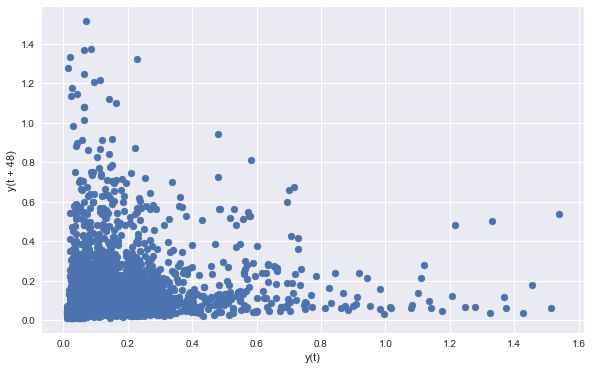

In [ ]:
data['unit0'] = df.iloc[:, 0]
pd.plotting.lag_plot(data['unit0'], lag=48)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 48)'>

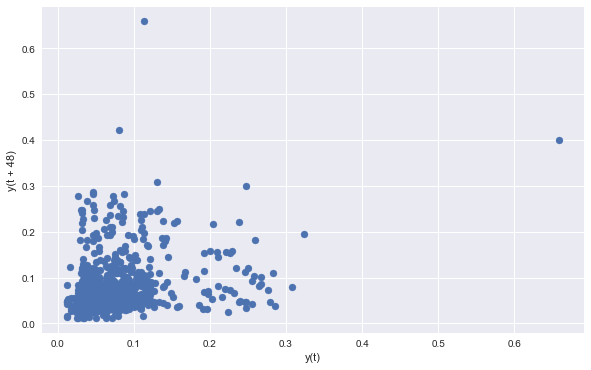

In [ ]:
data['unit0Night'] = df.iloc[:, 0]
data['unit0Night'] = data['unit0Night'][data['unit0Night'].index.time < datetime.time(6, 0)] 
pd.plotting.lag_plot(data['unit0Night'], lag=48)

## 1. Prophet for Daily Profile of Household 1

In [ ]:
#hide
data['tsPdDaily'] = df.iloc[:, 0].resample('1D', closed='left').mean()  # to pandas time series
ts_fb = data['tsPdDaily'].to_frame().reset_index()  # to Prophet time series
ts_fb.columns = ['ds', 'y']

In [ ]:
#hide
mod = Prophet()
mod.fit(ts_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Forcasts for future 3 days.

In [ ]:
#hide
future = mod.make_future_dataframe(periods=3)
forecast = mod.predict(future)

In [ ]:
#hide_input
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(3)

,ds,yhat,yhat_lower,yhat_upper
122,2017-12-01,0.135803,0.090711,0.183849
123,2017-12-02,0.159741,0.110367,0.206911
124,2017-12-03,0.154350,0.104546,0.199353


Line plot for forecasts and confidence interval of future 3 days.

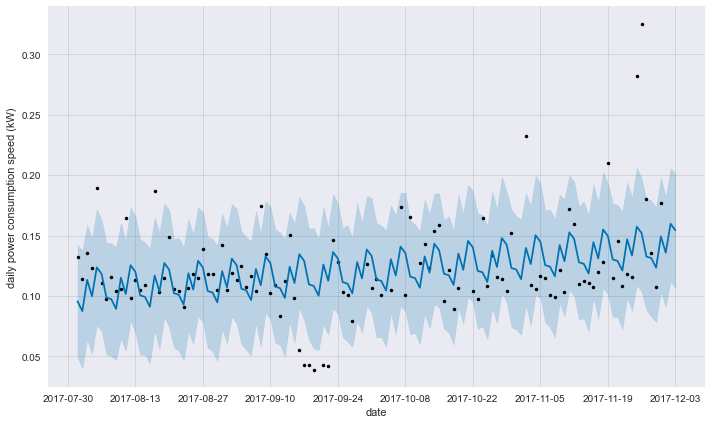

In [ ]:
#hide_input
mod.plot(forecast, xlabel='date', ylabel='daily power consumption speed (kW)');

Trending and weekly cycling components in the model.

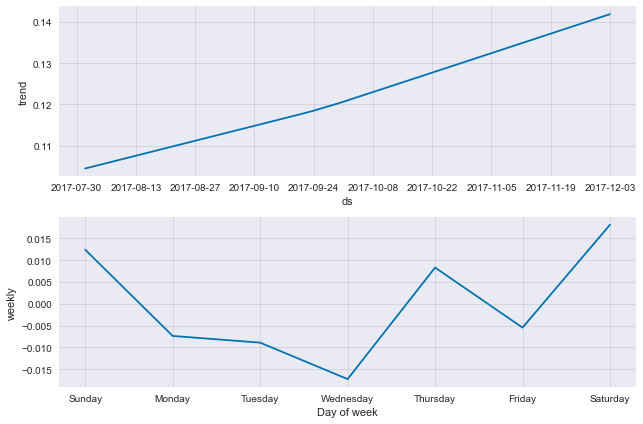

In [ ]:
#hide_input
mod.plot_components(forecast);

### Residual Analysis

In [ ]:
data['resDaily'] = forecast.loc[:121, ['ds', 'yhat']]
data['resDaily'].set_index('ds', inplace=True)

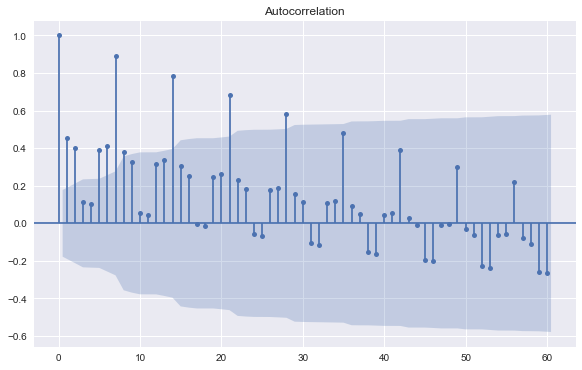

In [ ]:
plot_acf(data['resDaily'], lags=60);

/Users/edxu96/Library/Caches/pypoetry/virtualenvs/elec-consumption-FzRBkitR-py3.7/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


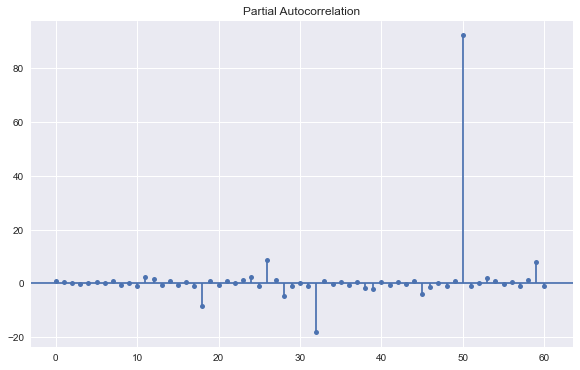

In [ ]:
plot_pacf(data['resDaily'], lags=60);

## 2. Prophet for Hourly Profile of Household 1

In [ ]:
#hide
ts_pd = df.iloc[:, 0].resample('1H', closed='left').mean()  # to pandas time series
ts_fb = ts_pd.to_frame().reset_index()  # to Prophet time series
ts_fb.columns = ['ds', 'y']
mod = Prophet()
mod.fit(ts_fb)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
#hide
future = mod.make_future_dataframe(periods=24, freq='H', include_history=True)
forecast = mod.predict(future)

Forecasts for future 4 hours.

In [ ]:
#hide_input
forecast.loc[2928:2931, ['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
2928,2017-12-01 00:00:00,0.157450,0.025331,0.291369
2929,2017-12-01 01:00:00,0.135131,0.000778,0.272809
2930,2017-12-01 02:00:00,0.115922,-0.027348,0.263052
2931,2017-12-01 03:00:00,0.108154,-0.018298,0.241419


Line plot for forecasts and confidence interval of future 24 hours.

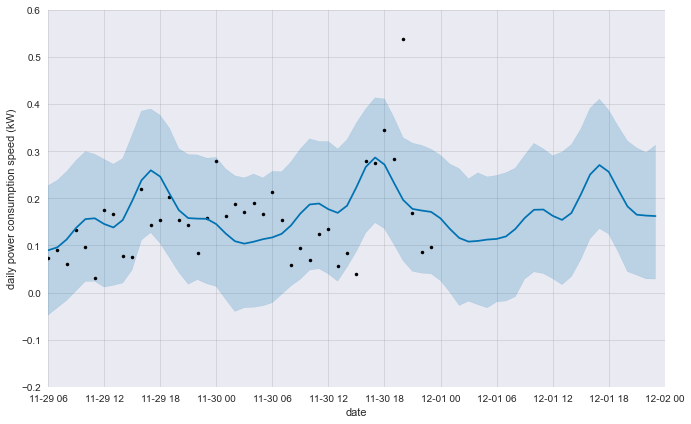

In [ ]:
#hide_input
_, ax = plt.subplots(1, 1)
ax.set_xlim([Timestamp('2017-11-29 06:00:00'), Timestamp('2017-12-02 00:00:00')])
ax.set_ylim([-0.2, 0.6])
mod.plot(forecast, ax=ax, xlabel='date', ylabel='daily power consumption speed (kW)');